# ９章 GLMのベイズモデル化と事後分布の推定
- [Pythonで実装しながら緑本を学ぶ (第9章 GLMのベイズモデル化と事後分布の推定)](https://ohke.hateblo.jp/entry/2018/03/08/230000)
- [pythonを用いてRDataからcsvに変換する](https://qiita.com/Atore2525_178/items/92bcf51c140ac0f2bd03)

In [1]:
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/yoshino/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline

In [3]:
%precision 3

'%.3f'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

### 9.1 例題：種子数のポアソン回帰(個体差なし)

In [6]:
import pyreadr
data = pyreadr.read_r('./data/chapter9/d.RData')
data = data['d']
data.head()

,x,y
0,3.000000,5.0
1,3.210526,3.0
2,3.421053,6.0
3,3.631579,7.0
4,3.842105,7.0


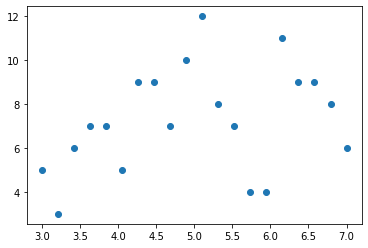

In [7]:
plt.scatter(data.x, data.y)

In [8]:
import statsmodels.formula.api as smf

result = smf.poisson('y ~ x', data=data).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 2.250894
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                        Poisson   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Wed, 25 Jan 2023   Pseudo R-squ.:                 0.01628
Time:                        21:04:20   Log-Likelihood:                -45.018
converged:                       True   LL-Null:                       -45.763
Covariance Type:            nonrobust   LLR p-value:                    0.2222
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5661      0.360      4.351      0.000       0.861       2.272
x              0.0833      0.068      1.219      0.223      -0.051       0.217
==============================================================================
"""

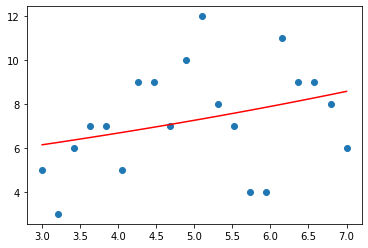

In [9]:
# 最尤推定で推測したポアソン分布の平均
mu = []
for x in data['x'].values:
  m = np.exp(result.params['Intercept'] + result.params['x'] * x)
  mu.append(m)

plt.scatter(data.x, data.y)
plt.plot(data['x'].values, mu, c='r')

### 9.3 無情報事前分布

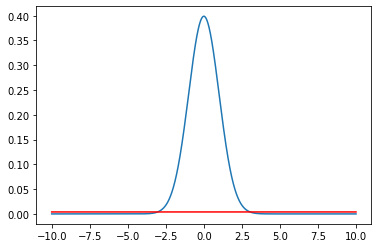

In [10]:
from scipy.stats import norm

x = np.arange(-10, 10.01, 0.01)

plt.plot(x, [norm.pdf(x_i, 0, 1) for x_i in x])
plt.plot(x, [norm.pdf(x_i, 0, 100) for x_i in x], c='r') # 無情報事前分布を平均0, 分散100の正規分布とする

### 9.4 ベイズ統計モデルの事後分布の推定

In [11]:
import pymc3

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [12]:
# np.float128ではエラーとなったのでfloat64に型変換
data['x'] = data['x'].astype(np.float64)
data['y'] = data['y'].astype(np.float64)

In [14]:
with pymc3.Model() as model:
  # 事前分布をN(0, 100)の正規分布で設定
  beta1 = pymc3.Normal('beta1', mu=0, sd=100)
  beta2 = pymc3.Normal('beta2', mu=0, sd=100)
  
  # 線系予測子Θをβ1+β2xで設定
  theta = beta1 + beta2 * data['x'].values

  # ログリンク関数を設定し(log(μ) <=> μ = exp(Θ))、ポアソン分布を推定する
  y = pymc3.Poisson('y', mu=np.exp(theta), observed=data['y'].values)

Multiprocess sampling (3 chains in 3 jobs)
HamiltonianMC: [beta2, beta1]


Sampling 3 chains for 200 tune and 1_500 draw iterations (600 + 4_500 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8856184725508153, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9147689495446927, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88360164847382, but should be close to 0.65. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


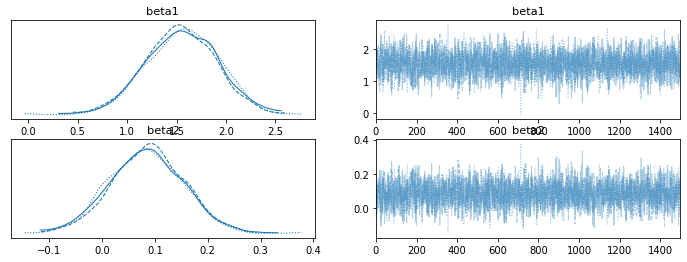

In [29]:
# ハミルトニアンモンテカルロ法
with model:
    # 101個目から3個置きでサンプルを取得するチェインを3つ作る
    # cores: チェイン数
    # tuneで、先頭から捨てるサンプル数を指定する
    trace = pymc3.sample(1500, step=pymc3.HamiltonianMC(), tune=200, cores=3)
    
pymc3.traceplot(trace)
plt.show()

In [24]:
pymc3.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.569,0.367,0.862,2.229,0.009,0.006,1673.0,2122.0,1.0
beta2,0.082,0.069,-0.047,0.210,0.002,0.001,1690.0,2272.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


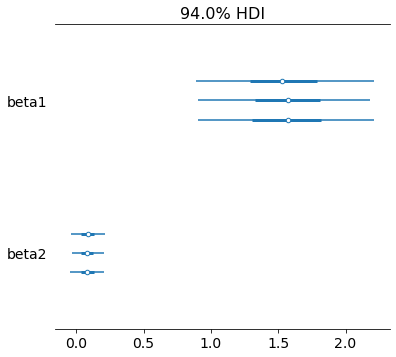

In [27]:
# forestplot()関数では、各パラメータについて、各 chain のベイズ信頼区間を表示
pymc3.forestplot(trace)
plt.show()

In [28]:
print('Trace type:', type(trace)) # Trace type: <class 'pymc3.backends.base.MultiTrace'>
print('Trace length:', len(trace)) # Trace length: 500
print('trace[0]:', trace[0]) # trace[0]: {'beta1': 2.0772965015391716, 'beta2': -0.02971672503615687}

Trace type: <class 'pymc3.backends.base.MultiTrace'>
Trace length: 1500
trace[0]: {'beta1': 1.7441744788467985, 'beta2': 0.06706721693459651}


Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]


Sampling 3 chains for 1_200 tune and 3_500 draw iterations (3_600 + 10_500 draws total) took 2 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.513,0.315,0.930,2.100,0.045,0.033,51.0,92.0,1.05
beta2,0.092,0.059,-0.017,0.202,0.008,0.006,51.0,64.0,1.04


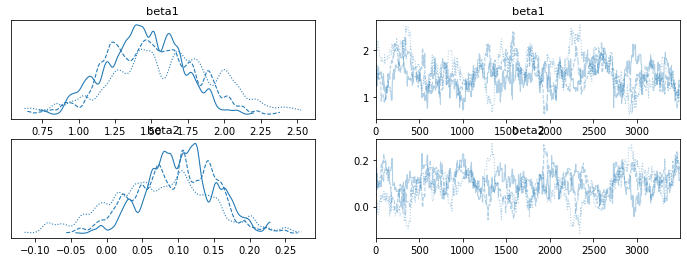

In [34]:
# メトロポリス法
# ハミルトニアンモンテカルロ法に比較して、サンプル数、サンプルを捨てる数(tune)を大きい値にする必要がある
with model:
    # 101個目から3個置きでサンプルを取得するチェインを3つ作る
    trace_Metropolis = pymc3.sample(3500, step=pymc3.Metropolis(), tune=1200, cores=3)

_ = pymc3.traceplot(trace_Metropolis)

pymc3.summary(trace_Metropolis)

### 9.5 MCMCサンプルから事後分布を推定

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


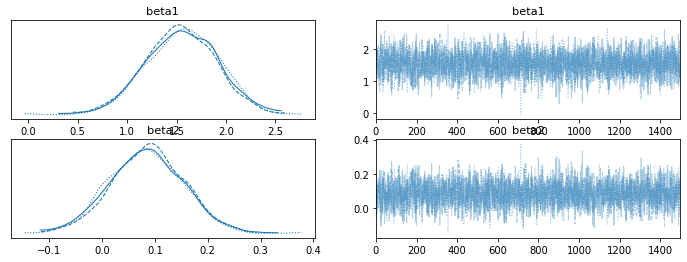

In [35]:
pymc3.traceplot(trace)
plt.show()

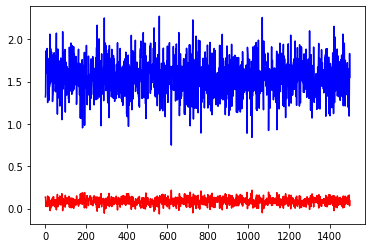

In [39]:
# 同時事後分布p(β1,β2|Y)のプロット
beta1_averages = np.zeros(len(trace), dtype=np.float64)
beta2_averages = np.zeros(len(trace), dtype=np.float64)

for i in trace.chains:
  beta1_averages += trace.get_values('beta1', chains=i) / trace.nchains
  beta2_averages += trace.get_values('beta2', chains=i) / trace.nchains

plt.plot(beta1_averages, c='b')
plt.plot(beta2_averages, c='r')

Text(0, 0.5, 'beta2')

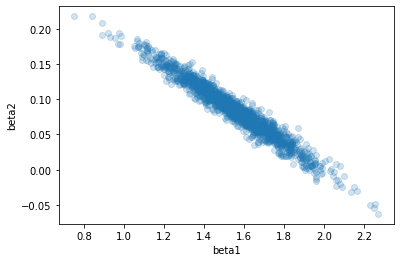

In [40]:
# 同時事後分布p(β1,β2|Y)を散布図でプロット
plt.scatter(beta1_averages, beta2_averages, alpha=0.2)
plt.xlabel('beta1')
plt.ylabel('beta2')

In [41]:
# ハミルトニアンモンテカルロ法の事後分布の統計量を表示(再掲)
pymc3.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.551,0.359,0.909,2.244,0.006,0.004,3573.0,3365.0,1.0
beta2,0.085,0.068,-0.046,0.209,0.001,0.001,3640.0,3645.0,1.0
